<a href="https://colab.research.google.com/github/shubhamrai1318/Recommendation_System_for_E-commerce/blob/main/Recommendation_For_Ecom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Recommendation System for E-commerce**

## **Importing libraries**


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds

## **Loading Dataset**

In [2]:
# Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Loading the Dataset
file_path = '/content/drive/MyDrive/Shubham/CsvFiles/ratings_Electronics.csv'
df = pd.read_csv(file_path)

## **Data Manipulation**

In [5]:
df

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600
...,...,...,...,...
438055,A3I8R0PC35026S,B000281XGK,5.0,1158710400
438056,A1PEHAK2DVOXM6,B000281XGU,4.0,1217030400
438057,A1FA0W63Z9LH18,B000281Z6I,1.0,1123632000
438058,A1BWJ4VRY2Q6YQ,B000281Z6I,2.0,1109548800


In [7]:
# Adding Column Names
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']
df

,user_id,prod_id,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600
...,...,...,...,...
438055,A3I8R0PC35026S,B000281XGK,5.0,1158710400
438056,A1PEHAK2DVOXM6,B000281XGU,4.0,1217030400
438057,A1FA0W63Z9LH18,B000281Z6I,1.0,1123632000
438058,A1BWJ4VRY2Q6YQ,B000281Z6I,2.0,1109548800


In [8]:
#Dropping timestamp
df = df.drop('timestamp', axis=1)

In [12]:
# Rows and Columns of Dataset
rows, columns = df.shape
print("There are", rows , "Rows")
print("There are", columns,"Columns")

There are 438060 Rows
There are 3 Columns


In [13]:
# Datatypes of Columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438060 entries, 0 to 438059
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  438060 non-null  object 
 1   prod_id  438060 non-null  object 
 2   rating   438060 non-null  float64
dtypes: float64(1), object(2)
memory usage: 10.0+ MB


In [14]:
# Find number of missing values in each column
df.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

In [15]:
# Summary statistics of 'rating' variable
df.describe()

,rating
count,438060.000000
mean,3.971340
std,1.400363
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


In [17]:
#Finding the minimum and maximum ratings
print('Minimum rating is: %d' %(df.rating.min()))
print('Maximum rating is: %d' %(df.rating.max()))

Minimum rating is: 1
Maximum rating is: 5


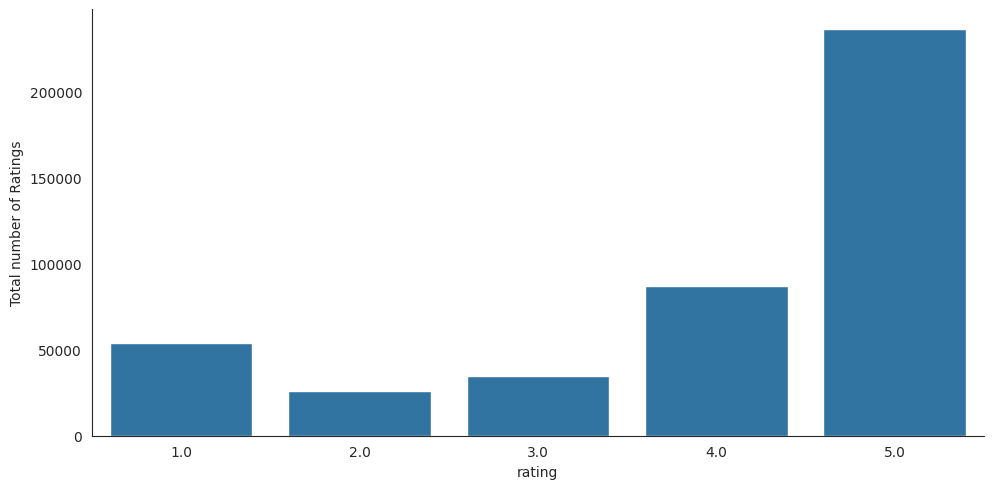

In [27]:
# Checking the distribution of the rating
with sns.axes_style('white'):
    g = sns.catplot(x="rating", data=df, aspect=2.0, kind='count')
    g.set_ylabels("Total number of Ratings")


In [33]:
# Number of unique user id  in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
# Number of unique product id  in the data
print('Number of unique PRODUCTS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  357684
Number of unique PRODUCTS in Raw data =  27236


In [30]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
A5JLAU2ARJ0BO     277
A231WM2Z2JL0U3    246
A25HBO5V8S8SEA    151
AKT8TGIT6VVZ5      82
A2AEZQ3DGBBLPR     75
A11D1KHM7DVOQK     72
A6FIAB28IS79       72
AT6CZDCP4TRGA      70
A2B7BUH8834Y6M     70
ABH9D1TEOJ56E      64
dtype: int64